# Predicting house prices

**Why?**

# Scope

The dataset has been downloaded from [Kaggle](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data)

## About the data

# Set-up

## Dependencies

In [1]:
import sys
CONFIG_DIRECTORY = 'C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\house-price-regression\\house-price-regression'
if CONFIG_DIRECTORY not in sys.path:
    sys.path.insert(0, CONFIG_DIRECTORY)

import ast
import config
import datetime
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
plt.style.use('seaborn-v0_8-muted')

## Import data

In [2]:
train_df = pd.read_csv(config.file_directory('cleaned') + 'train_df.csv')
print(f"Number of records: {train_df.shape[0]}")
print(f"Number of columns: {train_df.shape[1]}")
train_df.head()

Number of records: 14480
Number of columns: 17


,bathrooms,bedrooms,condition,floors,grade,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated_bool,price,zipcode_price
0,1.75,3,4,1.5,8,1910,0,1910,1820,17003,14806,0,0,1963,0,175000.0,4
1,1.75,2,4,1.0,7,1490,0,1490,2280,9874,9869,0,0,1963,0,898000.0,4
2,1.75,4,4,1.0,8,1990,0,1990,2620,8900,8925,0,0,1972,0,745000.0,4
3,2.50,4,3,2.0,8,2200,940,3140,2860,7260,8186,0,0,2004,0,744000.0,4
4,3.50,5,3,2.0,11,3480,1320,4800,4050,14984,19009,2,0,1998,0,1350000.0,4


In [3]:
transformed_train_df = pd.read_csv(config.file_directory('cleaned') + 'transformed_train_df.csv')
print(f"Number of records: {transformed_train_df.shape[0]}")
print(f"Number of columns: {transformed_train_df.shape[1]}")
transformed_train_df.head()

Number of records: 14480
Number of columns: 17


,bathrooms_qt,bedrooms_qt,condition_qt,floors_qt,grade_qt,price_qt,sqft_above_qt,sqft_basement_qt,sqft_living15_qt,sqft_living_qt,sqft_lot15_qt,sqft_lot_qt,view_qt,waterfront,yr_built_qt,yr_renovated_bool,zipcode_price_qt
0,0.523537,-0.336178,-0.425228,0.741388,-0.473810,0.006273,0.695908,-5.199338,0.802226,0.366873,-0.716962,0.056997,-5.199338,0,0.868016,0,0.181652
1,-1.318946,-0.336178,-0.425228,-5.199338,-0.473810,-0.785036,-1.066304,-5.199338,-1.934489,-1.391202,-0.625670,-0.573922,-5.199338,0,-1.334066,0,-0.308427
2,2.013671,1.625274,-0.425228,0.741388,1.654145,1.592263,2.183535,-5.199338,1.387908,1.885031,0.112519,0.152955,1.550085,0,1.197193,0,-0.308427
3,0.067799,0.691121,-0.425228,0.741388,0.429351,-0.691121,0.754664,-5.199338,0.619578,0.433482,0.287255,-0.038901,-5.199338,0,0.189310,0,-0.308427
4,0.523537,-0.336178,-0.425228,0.741388,-0.473810,0.408688,0.598435,-5.199338,0.582009,0.239380,-0.980828,-0.935852,-5.199338,0,0.824933,0,-0.308427


In [4]:
test_df = pd.read_csv(config.file_directory('cleaned') + 'test_df.csv')
print(f"Number of records: {test_df.shape[0]}")
print(f"Number of columns: {test_df.shape[1]}")
test_df.head()

Number of records: 7133
Number of columns: 17


,bathrooms,bedrooms,condition,floors,grade,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated_bool,price,zipcode_price
0,1.50,2,3,3.0,7,1430,0,1430,1430,1650,1650,0,0,1999,0,297000.0,2
1,3.25,4,4,2.0,12,4670,0,4670,4230,51836,41075,0,0,1988,0,1578000.0,4
2,0.75,2,3,1.0,7,1200,240,1440,1440,3700,4300,0,0,1914,0,562100.0,4
3,1.00,2,4,1.0,8,1130,0,1130,1680,2640,3200,0,0,1927,0,631500.0,4
4,2.50,4,3,2.0,9,3180,0,3180,2440,9603,15261,2,0,2002,0,780000.0,0


# Ordinary least squares

## Background

* We assume the below linear model exists:

    $Y = b_0 + b_1X_1 + b_2X_2 + ... + b_pX_p + e$

* Where fitted values are given by:

    $\hat{Y} = \hat{b}_0 + \hat{b}_1X_1 + \hat{b}_2X_2 + ... + \hat{b}_pX_p$

Note: A constant (b<sub>0</sub>) will be added to all models with a view to reducing bias (as this will force the mean of the residuals to zero).

*Assumptions:*
1) **The regression model is linear in the coefficients and the error term (i.e. all raised to the power of one)**

    Note: Linear regression models can model curvature by including nonlinear *variables* such as polynomials (e.g. X<sub>2</sub>)

2) **The error term has a mean of zero**

   Note: When the constant term (b<sub>0</sub>) is included, the mean of the residuals will be forced to zero.

3) **All independent variables are uncorrelated with the error term (AKA Exogeneity)**

    Note: If this is violated, it means the error term isn't unpredictable random error as we can predict it using the independent variables. It can indicate a missing variable or measurement error. It leads to bias in the coefficient estimates.

4) **Observations of the error term are uncorrelated with each other**

   Note: Observations of the error term should not have a natural sequential order (i.e. no autocorrelation). One observation of error term should not be predictive of the next observation. If this occurs, additional information can be incorporated into the model.

5) **The error term has constant variance (AKA Heteroscedasticity)**

   Note: The variance of the error observations should be constant.

   Note: When assumptions 4 and 5 hold, the error term is independant and identically distributed (I.I.D)

7) **No independent variable is a perfect linear function of other explanatory variables**

   Note: Ordinary least squares cannot distinguish one variable from the other when they are perfectly correlated. This prevents the model fitting and will result in an error message. Imperfect but strong correlation (i.e. multicollinearity) leads to unstable coefficient estimates.

8) **The error term is normally distributed (optional)**

   Note: This is crucial for accurate estimates of confidence/prediction intervals and p-values for coefficient estimates. However, its not required for unbiased estimates.

*Key metrics:*

* Root mean square error (the square root of the average squared error in the predicted values):
  
    $ RMSE = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}}$

* R-squared statistic (the proportion of variation in the data accounted for in the model -- ranges from 0 to 1):

    $ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y}_i)^2}$

* Adjusted R-squared statistic (P = no. of parameters, n = no. of records):

    $ R^2_{adj} = 1 - (1-R^2) \frac{n-1}{n-P-1} $

* Akaike's Information Criteria (RSS = residual sum of squares)

    $ AIC = 2P + nlog(\frac{RSS}{n}) = 2P + nlog(\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}) $

## Starting model

### Forward selection
* Stepwise regression will be used to determine which variables should be included in the model. This will involve successively adding variables to a starting model (AKA forward selection).

* For training data, the inclusion of additional variables will always reduce root mean square error (RMSE) and increase R-squared. Stepwise regression can therefore result in overfitting and poor generalisation.

* To avoid overfitting, model complexity will be penalised using an adjusted R-squared metric.

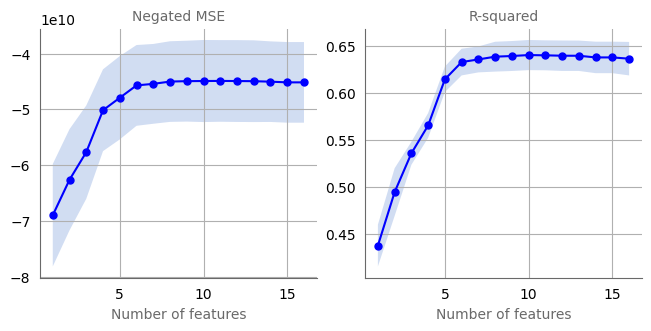

In [5]:
X = train_df.iloc[:, train_df.columns != 'price']
y = train_df.iloc[:, train_df.columns == 'price']

# Negated MSE
lr = LinearRegression()
sfs_mse = SFS(lr, k_features=X.shape[1], forward=True, floating=False, scoring='neg_mean_squared_error', cv=10)
sfs_mse = sfs_mse.fit(X, y)
mse_avg = {key: value['avg_score'] for key, value in sfs_mse.get_metric_dict().items()}
mse_SE = {key: value['std_err'] for key, value in sfs_mse.get_metric_dict().items()}

# R-squared
lr = LinearRegression()
sfs_r2 = SFS(lr, k_features=X.shape[1], forward=True, floating=False, scoring='r2', cv=10)
sfs_r2 = sfs_r2.fit(X, y)
r2_avg = {key: value['avg_score'] for key, value in sfs_r2.get_metric_dict().items()}
r2_SE = {key: value['std_err'] for key, value in sfs_r2.get_metric_dict().items()}

# Aggregate scores & plot
sfs_scores = pd.concat([pd.DataFrame.from_dict(mse_avg, orient='index', columns=['mse']),
                        pd.DataFrame.from_dict(mse_SE, orient='index', columns=['mse_SE']),
                        pd.DataFrame.from_dict(r2_avg, orient='index', columns=['r2']),
                        pd.DataFrame.from_dict(r2_SE, orient='index', columns=['r2_SE'])
                       ],
                       axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5))
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(True)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_xlabel('Number of features', fontsize=10, color='dimgray')
axes[0].set_title('Negated MSE', fontsize=10, color='dimgray')
axes[1].set_title('R-squared', fontsize=10, color='dimgray');

axes[0].plot(sfs_scores['mse'], color='blue', marker='.', markersize='10')
axes[0].fill_between(sfs_scores.index, sfs_scores['mse'] - sfs_scores['mse_SE'], sfs_scores['mse'] + sfs_scores['mse_SE'], alpha=0.25)
axes[1].plot(sfs_scores['r2'], color='blue', marker='.', markersize='10')
axes[1].fill_between(sfs_scores.index, sfs_scores['r2'] - sfs_scores['r2_SE'], sfs_scores['r2'] + sfs_scores['r2_SE'], alpha=0.25);

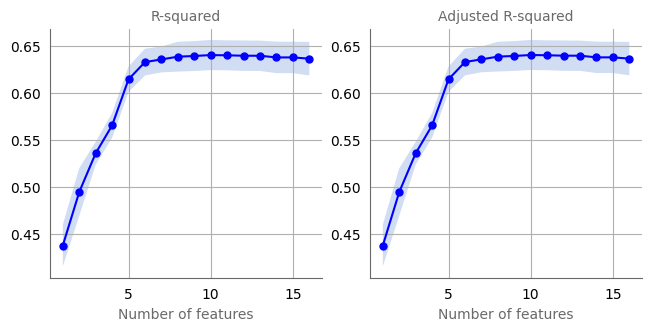

In [6]:
# Adjusted R-squared
def calc_adj_r2(r2, n, P):
    return 1 - (1-r2)*((n-1)/(n-P-1))

adj_r2_avg = {key: calc_adj_r2(value['avg_score'], train_df.shape[0], len(sfs_r2.get_metric_dict()[1]['feature_names'])) for key, value in sfs_r2.get_metric_dict().items()}
adj_r2_SE = {key: calc_adj_r2(value['std_err'], train_df.shape[0], len(sfs_r2.get_metric_dict()[1]['feature_names'])) for key, value in sfs_r2.get_metric_dict().items()}
sfs_scores = pd.concat([sfs_scores,
                        pd.DataFrame.from_dict(adj_r2_avg, orient='index', columns=['adj_r2']),
                        pd.DataFrame.from_dict(adj_r2_SE, orient='index', columns=['adj_r2_SE'])
                       ],
                       axis=1)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5))
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(True)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_xlabel('Number of features', fontsize=10, color='dimgray')
axes[0].set_title('R-squared', fontsize=10, color='dimgray')
axes[1].set_title('Adjusted R-squared', fontsize=10, color='dimgray');

axes[0].plot(sfs_scores['r2'], color='blue', marker='.', markersize='10')
axes[0].fill_between(sfs_scores.index, sfs_scores['r2'] - sfs_scores['r2_SE'], sfs_scores['r2'] + sfs_scores['r2_SE'], alpha=0.25)
axes[1].plot(sfs_scores['adj_r2'], color='blue', marker='.', markersize='10')
axes[1].fill_between(sfs_scores.index, sfs_scores['adj_r2'] - sfs_scores['adj_r2_SE'], sfs_scores['adj_r2'] + sfs_scores['adj_r2_SE'], alpha=0.25);

In [7]:
print(f"Features tested: {list(X.columns)}")
print('\n')
print(f"Optimum subset of features as per MSE: {sfs_mse.get_metric_dict()[6]['feature_names']}")
print(f"Optimum subset of features as per R-squared: {sfs_r2.get_metric_dict()[6]['feature_names']}")

Features tested: ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront', 'yr_built', 'yr_renovated_bool', 'zipcode_price']


Optimum subset of features as per MSE: ('grade', 'sqft_living', 'view', 'waterfront', 'yr_built', 'zipcode_price')
Optimum subset of features as per R-squared: ('grade', 'sqft_living', 'view', 'waterfront', 'yr_built', 'zipcode_price')


### Fit model
***Key observations:***

* The non-normality of residuals means confidence intervals, t statistics and p-values for coefficients may not be accurate.

*R-squared*
* R-squared provides an indication of the strength of the relationship between the model and the response variable
* The model explains 66.3% of variance in the dependent variable (i.e. price)

*F-statistic*
* The F-statistic in the linear model output display is the statistic for testing whether any of the independent variables are significant. It is calculated assuming the null hypothesis is true.
* In this instance, the null hypothesis can be rejected as the p-value is 0.00 (below the significance level of 0.05)
* Where the null hypothesis is all regression coefficients (other than the constant) are equal to zero and the alternative hypothesis is at least one is not equal to zero.

$H_0: \beta_1 = ... =\beta_{p-1} = 0 $

$H_1: \beta_j \neq 0 \text{ for at least one value of j} $

*Regression coefficients*
* All coefficients are positive with the exception of yr_built. None of the confidence intervals are close to zero.
* The t statistic provides an indication of the significance of a coefficient. The higher it is (and the lower the p-value), the more significant the predictor.
* In this instance, the null hypothesis can be rejected for all coefficients as the p-values for each t-statistic are approximately 0.00 (below the significance level of 0.05)
* Where the null hypothesis is a regression coefficient is equal to zero.

$H_0: \beta_i = 0 $

$H_1: \beta_i \neq 0 $

$t_b = \frac{\hat{b}}{SE(\hat{b})} $

In [8]:
# Define predictor and response variables
# predictors = ['grade', 'sqft_living', 'view', 'waterfront', 'yr_built', 'zipcode_price']
predictors = ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront', 'yr_built', 'yr_renovated_bool', 'zipcode_price']
X = sm.add_constant(train_df[predictors]) # Stats models does not add a constant by default
y = train_df['price']

# Fit model
model = sm.OLS(y, X)
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     1972.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:38:26   Log-Likelihood:            -1.9776e+05
No. Observations:               14480   AIC:                         3.956e+05
Df Residuals:                   14464   BIC:                         3.957e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.282e+06   1.64e+05     32.150      0.000    4.96e+06     5.6e+06
bathrooms          3.729e+04   4051.874      9.202      0.000    2.93e+04    4.52e+04
bedrooms          -3.074e+04   2334.826    -13.164      0.000   -3.53e+04   -2.62e+04
condition          2.035e+04   2925.623      6.955      0.000    1.46e+04    2.61e+04
floors             2.225e+04   4414.503      5.040      0.000    1.36e+04    3.09e+04
grade              1.123e+05   2655.087     42.293      0.000    1.07e+05    1.17e+05
sqft_above           50.1207      2.740     18.294      0.000      44.750      55.491
sqft_basement        50.1135      3.261     15.369      0.000      43.722      56.505
sqft_living         100.2342      2.836     35.349      0.000      94.676     105.792
sqft_living15        31.5298      4.174      7.554      0.000      23.348      39.711
sqft_lot              0.1198      0.060      1.996      0.046       0.002       0.238
sqft_lot15           -0.4796      0.096     -5.001      0.000      -0.668      -0.292
view               4.534e+04   2694.064     16.831      0.000    4.01e+04    5.06e+04
waterfront          6.17e+05   2.12e+04     29.147      0.000    5.76e+05    6.59e+05
yr_built          -3120.7693     84.225    -37.053      0.000   -3285.862   -2955.677
yr_renovated_bool  1.512e+04   9057.829      1.670      0.095   -2631.912    3.29e+04
zipcode_price      3.302e+04   1353.515     24.396      0.000    3.04e+04    3.57e+04
==============================================================================
Omnibus:                     8665.811   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267112.168
Skew:                           2.349   Prob(JB):                         0.00
Kurtosis:                      23.510   Cond. No.                     1.07e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.37e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Goodness of fit
***Key observations:***
* Root mean square error needs to be minimised. It is difficult to interpret without some benchmark.
* Log-likelihood needs to be maximised (it can range from negative infinity to positive infinity). It is difficult to interpret without some benchmark.

In [9]:
# RMSE
ypred = fit_model.predict(X)
rmse = sm.tools.eval_measures.rmse(y, ypred)
print(f"RMSE: {round(rmse, 2)}")

# # R-squared / Adjusted R-squared / AIC
# print(f"R-squared: {round(fit_model.rsquared, 2)}")
# print(f"Adjusted R-squared: {round(fit_model.rsquared_adj, 2)}")
# print(f"AIC: {round(fit_model.aic, 2)}")

RMSE: 206600.3


### Residual diagnostics
***Key observations:***

* The quality of predictions appears to decrease as house price increasess.

*Homoscedasticity*
* A plot of standardised residuals versus actual prices shows the variance of the residuals is not constant. It increases for records with high prices.

*Normality*
* A histogram and q-q plot for standardised residuals confirms a non-normal distribution for residuals.
* This observation is confirmed by the kurtosis (22.67) and skew (2.3) given above. This is also reflected in the jaque-bera statistic, which is close to zero when skew and kurtosis match a normal distribution.

*Correlation*
* The Durbin Watson statistic is used to test for autocorrelation (AKA serial correlation)
* A value close to 2 is reported to indicate no autocorrelation ([source](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic)). However, the plot of residuals versus actual price suggests some autocorrelation.

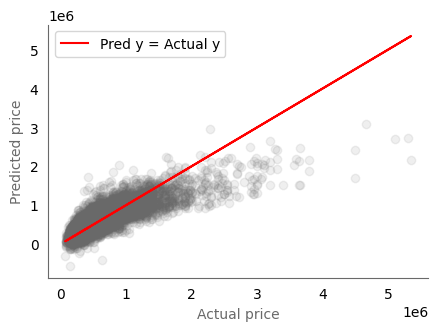

In [10]:
ypred = fit_model.predict(X)

fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(y, ypred, color='dimgray', alpha=0.1)
axes.plot(y, y, color='red', label='Pred y = Actual y')
axes.set_xlabel('Actual price', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted price', fontsize=10, color='dimgray')
axes.legend();

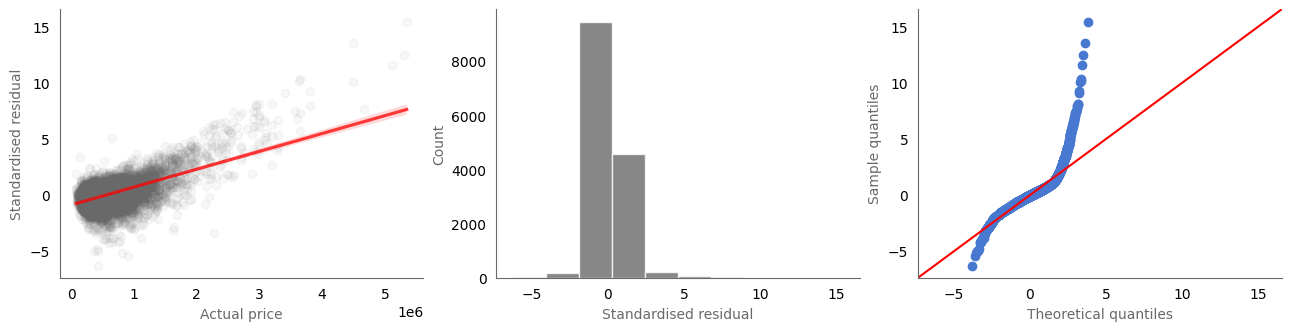

In [11]:
standardised_resids = fit_model.resid / fit_model.resid.std() # residual z-scores

fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(6.4*2, 4.8/1.5))
axes = axes.flatten()
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

sns.regplot(x=y, y=standardised_resids, line_kws={'color':'red', 'alpha': 0.75}, scatter_kws={'color':'dimgray', 'alpha':0.05}, ax=axes[0])
axes[0].set_xlabel('Actual price', fontsize=10, color='dimgray')
axes[0].set_ylabel('Standardised residual', fontsize=10, color='dimgray')

axes[1].hist(standardised_resids, color='dimgray', alpha=0.8, edgecolor ="white")
axes[1].set_xlabel('Standardised residual', fontsize=10, color='dimgray')
axes[1].set_ylabel('Count', fontsize=10, color='dimgray')

sm.qqplot(standardised_resids, line ='45', ax=axes[2])
axes[2].set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
axes[2].set_ylabel('Sample quantiles', fontsize=10, color='dimgray');

## Transform features
***Key observations:***
* The high residual associated with some records suggests the presence of outliers. To minimise their effect, all quantitative variables will be quantile transformed to a normal distribution.

### Foward selection

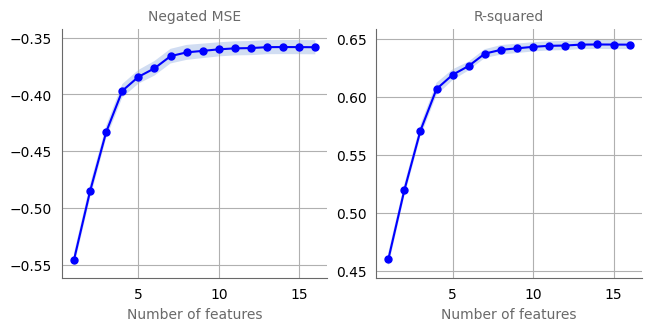

In [12]:
X = transformed_train_df.iloc[:, transformed_train_df.columns != 'price_qt']
y = transformed_train_df.iloc[:, transformed_train_df.columns == 'price_qt']

# Negated MSE
lr = LinearRegression()
sfs_mse = SFS(lr, k_features=X.shape[1], forward=True, floating=False, scoring='neg_mean_squared_error', cv=10)
sfs_mse = sfs_mse.fit(X, y)
mse_avg = {key: value['avg_score'] for key, value in sfs_mse.get_metric_dict().items()}
mse_SE = {key: value['std_err'] for key, value in sfs_mse.get_metric_dict().items()}

# R-squared
lr = LinearRegression()
sfs_r2 = SFS(lr, k_features=X.shape[1], forward=True, floating=False, scoring='r2', cv=10)
sfs_r2 = sfs_r2.fit(X, y)
r2_avg = {key: value['avg_score'] for key, value in sfs_r2.get_metric_dict().items()}
r2_SE = {key: value['std_err'] for key, value in sfs_r2.get_metric_dict().items()}

# Aggregate scores & plot
sfs_scores = pd.concat([pd.DataFrame.from_dict(mse_avg, orient='index', columns=['mse']),
                        pd.DataFrame.from_dict(mse_SE, orient='index', columns=['mse_SE']),
                        pd.DataFrame.from_dict(r2_avg, orient='index', columns=['r2']),
                        pd.DataFrame.from_dict(r2_SE, orient='index', columns=['r2_SE'])
                       ],
                       axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5))
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(True)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_xlabel('Number of features', fontsize=10, color='dimgray')
axes[0].set_title('Negated MSE', fontsize=10, color='dimgray')
axes[1].set_title('R-squared', fontsize=10, color='dimgray');

axes[0].plot(sfs_scores['mse'], color='blue', marker='.', markersize='10')
axes[0].fill_between(sfs_scores.index, sfs_scores['mse'] - sfs_scores['mse_SE'], sfs_scores['mse'] + sfs_scores['mse_SE'], alpha=0.25)
axes[1].plot(sfs_scores['r2'], color='blue', marker='.', markersize='10')
axes[1].fill_between(sfs_scores.index, sfs_scores['r2'] - sfs_scores['r2_SE'], sfs_scores['r2'] + sfs_scores['r2_SE'], alpha=0.25);

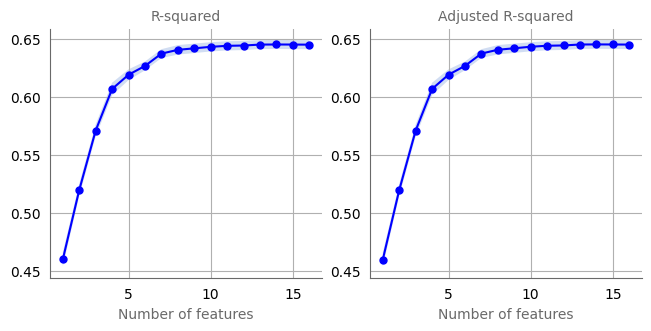

In [13]:
# Adjusted R-squared
def calc_adj_r2(r2, n, P):
    return 1 - (1-r2)*((n-1)/(n-P-1))

adj_r2_avg = {key: calc_adj_r2(value['avg_score'], transformed_train_df.shape[0], len(sfs_r2.get_metric_dict()[1]['feature_names'])) for key, value in sfs_r2.get_metric_dict().items()}
adj_r2_SE = {key: calc_adj_r2(value['std_err'], transformed_train_df.shape[0], len(sfs_r2.get_metric_dict()[1]['feature_names'])) for key, value in sfs_r2.get_metric_dict().items()}
sfs_scores = pd.concat([sfs_scores,
                        pd.DataFrame.from_dict(adj_r2_avg, orient='index', columns=['adj_r2']),
                        pd.DataFrame.from_dict(adj_r2_SE, orient='index', columns=['adj_r2_SE'])
                       ],
                       axis=1)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5))
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(True)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_xlabel('Number of features', fontsize=10, color='dimgray')
axes[0].set_title('R-squared', fontsize=10, color='dimgray')
axes[1].set_title('Adjusted R-squared', fontsize=10, color='dimgray');

axes[0].plot(sfs_scores['r2'], color='blue', marker='.', markersize='10')
axes[0].fill_between(sfs_scores.index, sfs_scores['r2'] - sfs_scores['r2_SE'], sfs_scores['r2'] + sfs_scores['r2_SE'], alpha=0.25)
axes[1].plot(sfs_scores['adj_r2'], color='blue', marker='.', markersize='10')
axes[1].fill_between(sfs_scores.index, sfs_scores['adj_r2'] - sfs_scores['adj_r2_SE'], sfs_scores['adj_r2'] + sfs_scores['adj_r2_SE'], alpha=0.25);

In [14]:
print(f"Features tested: {list(X.columns)}")
print('\n')
print(f"Optimum subset of features as per MSE: {sfs_mse.get_metric_dict()[10]['feature_names']}")
print(f"Optimum subset of features as per R-squared: {sfs_r2.get_metric_dict()[10]['feature_names']}")

Features tested: ['bathrooms_qt', 'bedrooms_qt', 'condition_qt', 'floors_qt', 'grade_qt', 'sqft_above_qt', 'sqft_basement_qt', 'sqft_living15_qt', 'sqft_living_qt', 'sqft_lot15_qt', 'sqft_lot_qt', 'view_qt', 'waterfront', 'yr_built_qt', 'yr_renovated_bool', 'zipcode_price_qt']


Optimum subset of features as per MSE: ('bathrooms_qt', 'bedrooms_qt', 'condition_qt', 'grade_qt', 'sqft_living15_qt', 'sqft_living_qt', 'sqft_lot_qt', 'view_qt', 'yr_built_qt', 'zipcode_price_qt')
Optimum subset of features as per R-squared: ('bathrooms_qt', 'bedrooms_qt', 'condition_qt', 'grade_qt', 'sqft_living15_qt', 'sqft_living_qt', 'sqft_lot_qt', 'view_qt', 'yr_built_qt', 'zipcode_price_qt')


### Fit model
***Key observations:***

* The normality of residuals means confidence intervals, t statistics and p-values for coefficients should be more reliable than before transformation.

*R-squared*
* R-squared provides an indication of the strength of the relationship between the model and the response variable
* The model explains 64.5% of variance in the dependent variable (i.e. price)

*F-statistic*
* The F-statistic in the linear model output display is the statistic for testing whether any of the independent variables are significant. It is calculated assuming the null hypothesis is true.
* In this instance, the null hypothesis can be rejected as the p-value is 0.00 (below the significance level of 0.05)
* Where the null hypothesis is all regression coefficients (other than the constant) are equal to zero and the alternative hypothesis is at least one is not equal to zero.

$H_0: \beta_1 = ... =\beta_{p-1} = 0 $

$H_1: \beta_j \neq 0 \text{ for at least one value of j} $

*Regression coefficients*
* All coefficients are positive with the exception of sqft_lot_qt and yr_built_qt. None of the confidence intervals include 0.
* The t statistic provides an indication of the significance of a coefficient. The higher it is (and the lower the p-value), the more significant the predictor.
* In this instance, the null hypothesis can be rejected for all coefficients as the p-values for each t-statistic are approximately 0.00 (below the significance level of 0.05)
* Where the null hypothesis is a regression coefficient is equal to zero.

$H_0: \beta_i = 0 $

$H_1: \beta_i \neq 0 $

$t_b = \frac{\hat{b}}{SE(\hat{b})} $

In [15]:
# Define predictor and response variables
predictors = ['bathrooms_qt', 'bedrooms_qt', 'condition_qt', 'grade_qt', 'sqft_living15_qt', 'sqft_living_qt', 'sqft_lot_qt', 'view_qt', 'yr_built_qt', 'zipcode_price_qt']
# predictors = ['bathrooms_qt', 'bedrooms_qt', 'condition_qt', 'floors_qt', 'grade_qt', 'sqft_above_qt', 'sqft_basement_qt', 'sqft_living15_qt', 'sqft_living_qt', 'sqft_lot15_qt', 'sqft_lot_qt', 'view_qt', 'waterfront', 'yr_built_qt', 'yr_renovated_bool', 'zipcode_price_qt']
X = sm.add_constant(transformed_train_df[predictors]) # Stats models does not add a constant by default
y = transformed_train_df['price_qt']

# Fit model
model = sm.OLS(y, X)
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_qt   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     2624.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:38:46   Log-Likelihood:                -13139.
No. Observations:               14480   AIC:                         2.630e+04
Df Residuals:                   14469   BIC:                         2.638e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1166      0.012      9.741      0.000       0.093       0.140
bathrooms_qt         0.0672      0.009      7.427      0.000       0.050       0.085
bedrooms_qt         -0.0635      0.007     -8.643      0.000      -0.078      -0.049
condition_qt         0.0399      0.003     11.717      0.000       0.033       0.047
grade_qt             0.4134      0.009     45.490      0.000       0.396       0.431
sqft_living15_qt     0.1691      0.008     21.095      0.000       0.153       0.185
sqft_living_qt       0.3266      0.011     28.553      0.000       0.304       0.349
sqft_lot_qt         -0.1198      0.006    -20.472      0.000      -0.131      -0.108
view_qt              0.0461      0.002     19.367      0.000       0.041       0.051
yr_built_qt         -0.2053      0.006    -33.627      0.000      -0.217      -0.193
zipcode_price_qt     0.0536      0.002     32.702      0.000       0.050       0.057
==============================================================================
Omnibus:                      253.562   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.915
Skew:                          -0.292   Prob(JB):                     6.07e-62
Kurtosis:                       3.356   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Goodness of fit
***Key observations:***
* Root mean square error needs to be minimised. It cannot be compared directly to the previous model due to the change in unit.
* Log-likelihood needs to be maximised (it can range from negative infinity to positive infinity). It is difficult to interpret without some benchmark.

In [16]:
# RMSE
ypred = fit_model.predict(X)
rmse = sm.tools.eval_measures.rmse(y, ypred)
print(f"RMSE: {round(rmse, 2)}")

# # R-squared / Adjusted R-squared / AIC
# print(f"R-squared: {round(fit_model.rsquared, 2)}")
# print(f"Adjusted R-squared: {round(fit_model.rsquared_adj, 2)}")
# print(f"AIC: {round(fit_model.aic, 2)}")

RMSE: 0.6


### Residual diagnostics

***Key observations:***

* The quality of predictions appears to be more uniform across the full range of house prices.

*Heteroscedasticity*
* A plot of standardised residuals versus actual prices shows the variance of the residuals roughly constant.

*Normality*
* A histogram and q-q plot for standardised residuals confirms an approximately normal distribution for residuals.
* This observation is confirmed by the kurtosis and skew given above. A standard normal distribution has a kurtosis of 3 and skewness of 0. The model summary gives a value of 3.394 and -0.282. 
* It is also reflected in the jaque-bera statistic, which is closer to zero than before transformation.

*Correlation*
* The Durbin Watson statistic is used to test for autocorrelation (AKA serial correlation)
* A value close to 2 is reported to indicate no autocorrelation ([source](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic)). However, the plot of residuals versus actual price suggests some autocorrelation.

*Autocorrelation*
* No autocorrelation is observed. 
* The Durbin-Watson statistic is used to test for autocorrelation in residuals. A value of 2 indicates no autocorrelation ([source](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic)) The model summary gives a value of 1.957, which is higher than before transformation.

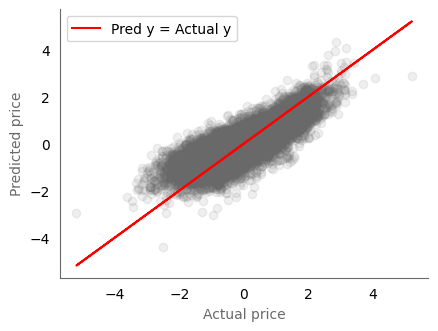

In [17]:
ypred = fit_model.predict(X)

fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(y, ypred, color='dimgray', alpha=0.1)
axes.plot(y, y, color='red', label='Pred y = Actual y')
axes.set_xlabel('Actual price', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted price', fontsize=10, color='dimgray')
axes.legend();

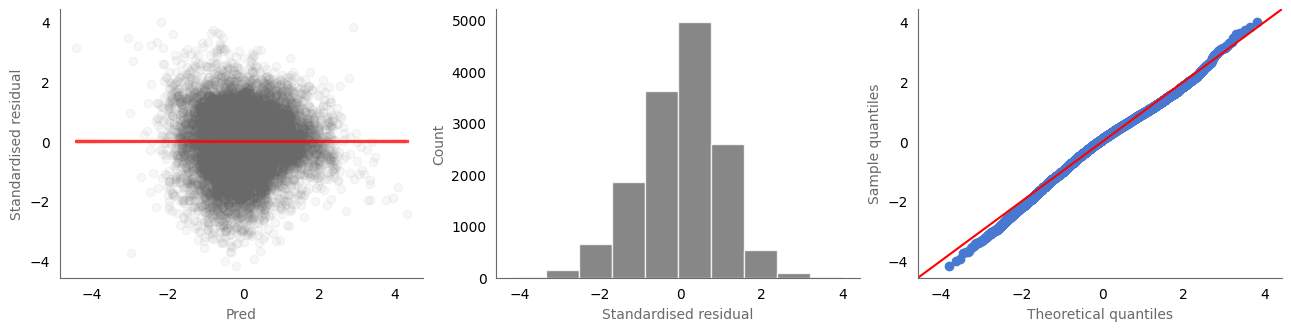

In [18]:
standardised_resids = fit_model.resid / fit_model.resid.std() # residual z-scores

fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(6.4*2, 4.8/1.5))
axes = axes.flatten()
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

sns.regplot(x=fit_model.fittedvalues, y=standardised_resids, line_kws={'color':'red', 'alpha': 0.75}, scatter_kws={'color':'dimgray', 'alpha':0.05}, ax=axes[0])
axes[0].set_xlabel('Pred', fontsize=10, color='dimgray')
axes[0].set_ylabel('Standardised residual', fontsize=10, color='dimgray')

axes[1].hist(standardised_resids, color='dimgray', alpha=0.8, edgecolor ="white")
axes[1].set_xlabel('Standardised residual', fontsize=10, color='dimgray')
axes[1].set_ylabel('Count', fontsize=10, color='dimgray')

sm.qqplot(standardised_resids, line ='45', ax=axes[2])
axes[2].set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
axes[2].set_ylabel('Sample quantiles', fontsize=10, color='dimgray');

### Outlier detection
* Outliers are points which behave differently to the rest of the data.

* We want to identify outliers which 'influence' model fitting and therefore parameters

#### Key terms

<img src="figures/leverage_discrepancy_influence.png" align="left" width="700" />

[Source](https://tillbe.github.io/outlier-influence-identification.html)

1. **Leverage**
* A point that is highly different in its predictor behavior than the rest of the data. The x-value of a predictor is either much higher or lower than the mean of the predictor.

2. **Discrepancy**
* If a point has an unusual y-value given its x-value, it has high discrepancy. This is what is called a outlier within the regression framework.

3. **Influence**
* High leverage *or* high discrepancy is not always enough to 'influence' model parameters. The influence of a single data point is defined as its leverage multiplied by its discrepancy.

**Assessing leverage**
* Key metric -- hat-value:

    $ h_i = \frac{1}{n} + \frac{(X_i - \bar{X})^2}{\sum_{j=1}^n (X_j - \bar{X})^2} $

* A standardized version of the distance to the mean of the predictor (X-bar) for each individual predictor point (X<sub>i</sub>). It is bound between 1/n and 1 (low and high leverage, respectively).

* Rule of thumb: Investigate points with hat-values above 2 times the average hat value. Where: p is the number of model parameters and n is the number of data points.

    $ h_{avg} = \frac{p + 1}{n} $

**Assessing discrepancy**
* Key metric -- studentized residuals:

    $ t_i = \frac{\hat{\epsilon_i}}{\hat{\sigma} \sqrt{1-h_i}} $

* Calculated by fitting a model without the case for which the residual is calculated, and then scaling the resulting residual by an estimate of the standard deviation of the newly fitted model's residuals and the point's leverage (hat-value)

* Rule of thumb: Studentized residuals follow a t-distribution. Points with studentized residuals greater than 3 are often investigated.

**Assessing influence**
* Key metric -- Cook's distance:
  
  $ D_i = \frac{\sum_{j=1}^n (\hat{Y}_i - \hat{Y}_{j(i)})^2}{ps^2} $

* Cook's distance for observation i is defined as the sum of all the changes in the regression model when observation i is removed from it. Where: p is the number of parameters in the model, Y<sub>i</sub> is the fitted value for the ith observation, Y<sub>j(i)</sub> is the fitted response value obtained when excluding i, p is the number of parameters and s<sup>2</sup> is the mean squared error of the regression model.

* It can also be expressed in terms of studentized residuals and hat-value:
  
  $ D_i = \frac{1}{p} .t^2. \frac{h_{ii}}{1-h_{ii}} $

* Rule of thumb: Investigate points with a Cook's distance above 4/(n-P-1). 

**References**
* https://stats.stackexchange.com/questions/319024/cooks-distance-vs-hat-values
* https://tillbe.github.io/outlier-influence-identification.html
* https://en.wikipedia.org/wiki/Cook%27s_distance
* https://en.wikipedia.org/wiki/Studentized_residual

#### Analyses
***Key observations***

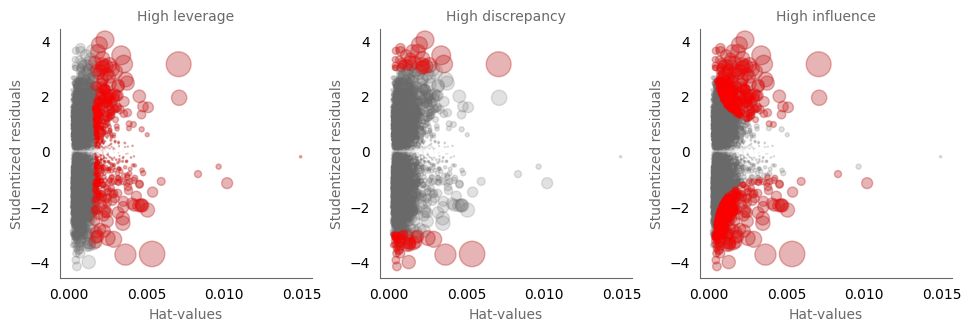

In [19]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Calc leverage, discrepancy and influence
influence = OLSInfluence(fit_model)
studentized_resids = influence.resid_studentized_internal
hat_vals = influence.hat_matrix_diag
cooks_distances = influence.cooks_distance[0]

# High leverage/discrepancy/influence points
n = X.shape[0]
p = X.shape[1]
is_leverage = hat_vals > (2*(p + 1)/n)
is_discrepancy = abs(studentized_resids) > 3
is_influential = cooks_distances > (4/(n - p - 1))

# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(6.4*1.5, 4.8/1.5))
for ax, highlighter in zip(axes, [is_leverage, is_discrepancy, is_influential]):
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.scatter(hat_vals, studentized_resids, s=50000*cooks_distances, color='dimgray', alpha=0.2)
    ax.scatter(hat_vals[highlighter], studentized_resids[highlighter], s=50000*cooks_distances[highlighter], color='red', alpha=0.2)
    ax.set_xlabel('Hat-values', fontsize=10, color='dimgray')
    ax.set_ylabel('Studentized residuals', fontsize=10, color='dimgray')
axes[0].set_title('High leverage', fontsize=10, color='dimgray')
axes[1].set_title('High discrepancy', fontsize=10, color='dimgray')
axes[2].set_title('High influence', fontsize=10, color='dimgray');

In [20]:
predictors = ['bathrooms_qt', 'bedrooms_qt', 'condition_qt', 'grade_qt', 'sqft_living15_qt',
              'sqft_living_qt', 'sqft_lot_qt', 'view_qt', 'yr_built_qt', 'zipcode_price_qt']

train_outliers = pd.concat([transformed_train_df[predictors + ['price_qt']],
                            pd.Series(hat_vals, name='hat_val'),
                            pd.Series(is_leverage, name='is_leverage'),
                            studentized_resids.rename('studentized_resid'),
                            is_discrepancy.rename('is_discrepancy'),
                            cooks_distances.rename('cooks_distance'),
                            is_influential.rename('is_influential')],
                           axis=1)

train_outliers = train_outliers.loc[is_leverage & is_discrepancy & is_influential].sort_values(
    by='cooks_distance', axis=0, ascending=False)

print(f"Number of outliers: {train_outliers.shape[0]}")
train_outliers.head()

Number of outliers: 20


,bathrooms_qt,bedrooms_qt,condition_qt,grade_qt,sqft_living15_qt,sqft_living_qt,sqft_lot_qt,view_qt,yr_built_qt,zipcode_price_qt,price_qt,hat_val,is_leverage,studentized_resid,is_discrepancy,cooks_distance,is_influential
7899,-5.199338,-5.199338,0.810910,-0.473810,-0.931971,-1.842181,-0.945929,-5.199338,-1.684464,5.199338,-2.549279,0.005341,True,-3.713181,True,0.006730,True
3600,-5.199338,-5.199338,-5.199338,-5.199338,-0.374936,-5.199338,1.261414,-5.199338,-0.299230,-1.016672,-2.524127,0.007053,True,3.147253,True,0.006396,True
6720,-5.199338,-2.575483,-0.425228,-3.208419,-1.545927,-2.575483,1.649674,-5.199338,-0.220058,-1.016672,-5.199338,0.003624,True,-3.736754,True,0.004616,True
9502,-5.199338,-2.575483,-2.542349,-3.208419,-2.107953,-2.877846,1.343511,-5.199338,-0.720087,0.181652,-0.959440,0.003350,True,3.469192,True,0.003678,True
3779,-1.318946,-1.449682,-0.425228,-2.483413,-0.931971,-1.890743,2.142921,-5.199338,1.197193,5.199338,0.248515,0.002302,True,4.024235,True,0.003397,True


## Remove outliers

### Fit model

In [21]:
is_not_outlier = transformed_train_df.index.isin(train_outliers.index)==False

In [22]:
# Define predictor and response variables
predictors = ['bathrooms_qt', 'bedrooms_qt', 'condition_qt', 'grade_qt', 'sqft_living15_qt', 'sqft_living_qt', 'sqft_lot_qt', 'view_qt', 'yr_built_qt', 'zipcode_price_qt']
X = sm.add_constant(transformed_train_df.loc[is_not_outlier, predictors]).reset_index(drop=True) # Stats models does not add a constant by default
y = transformed_train_df.loc[is_not_outlier, 'price_qt'].reset_index(drop=True)

# Fit model
model = sm.OLS(y, X)
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_qt   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     2656.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:38:50   Log-Likelihood:                -13018.
No. Observations:               14460   AIC:                         2.606e+04
Df Residuals:                   14449   BIC:                         2.614e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1113      0.012      9.344      0.000       0.088       0.135
bathrooms_qt         0.0658      0.009      7.290      0.000       0.048       0.083
bedrooms_qt         -0.0640      0.007     -8.757      0.000      -0.078      -0.050
condition_qt         0.0399      0.003     11.797      0.000       0.033       0.047
grade_qt             0.4204      0.009     46.446      0.000       0.403       0.438
sqft_living15_qt     0.1657      0.008     20.776      0.000       0.150       0.181
sqft_living_qt       0.3301      0.011     29.006      0.000       0.308       0.352
sqft_lot_qt         -0.1225      0.006    -21.041      0.000      -0.134      -0.111
view_qt              0.0451      0.002     19.027      0.000       0.040       0.050
yr_built_qt         -0.2118      0.006    -34.720      0.000      -0.224      -0.200
zipcode_price_qt     0.0533      0.002     32.756      0.000       0.050       0.057
==============================================================================
Omnibus:                      255.001   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.318
Skew:                          -0.307   Prob(JB):                     1.64e-60
Kurtosis:                       3.283   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Goodness of fit

In [23]:
# RMSE
ypred = fit_model.predict(X)
rmse = sm.tools.eval_measures.rmse(y, ypred)
print(f"RMSE: {round(rmse, 2)}")

# # R-squared / Adjusted R-squared / AIC
# print(f"R-squared: {round(fit_model.rsquared, 2)}")
# print(f"Adjusted R-squared: {round(fit_model.rsquared_adj, 2)}")
# print(f"AIC: {round(fit_model.aic, 2)}")

RMSE: 0.6


### Residual diagnostics

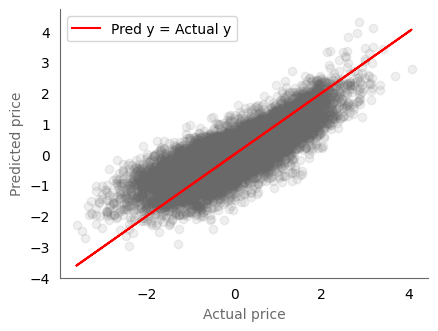

In [24]:
ypred = fit_model.predict(X)

fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(y, ypred, color='dimgray', alpha=0.1)
axes.plot(y, y, color='red', label='Pred y = Actual y')
axes.set_xlabel('Actual price', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted price', fontsize=10, color='dimgray')
axes.legend();

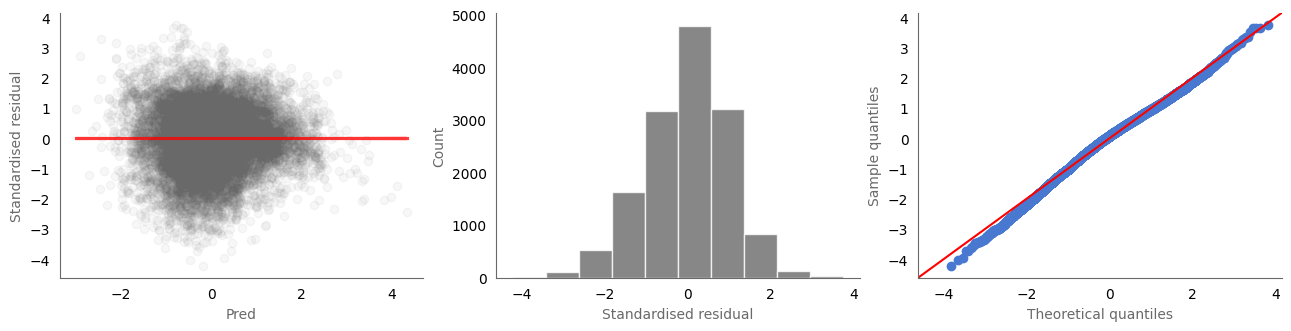

In [25]:
standardised_resids = fit_model.resid / fit_model.resid.std() # residual z-scores

fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(6.4*2, 4.8/1.5))
axes = axes.flatten()
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

sns.regplot(x=fit_model.fittedvalues, y=standardised_resids, line_kws={'color':'red', 'alpha': 0.75}, scatter_kws={'color':'dimgray', 'alpha':0.05}, ax=axes[0])
axes[0].set_xlabel('Pred', fontsize=10, color='dimgray')
axes[0].set_ylabel('Standardised residual', fontsize=10, color='dimgray')

axes[1].hist(standardised_resids, color='dimgray', alpha=0.8, edgecolor ="white")
axes[1].set_xlabel('Standardised residual', fontsize=10, color='dimgray')
axes[1].set_ylabel('Count', fontsize=10, color='dimgray')

sm.qqplot(standardised_resids, line ='45', ax=axes[2])
axes[2].set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
axes[2].set_ylabel('Sample quantiles', fontsize=10, color='dimgray');

### Cross-validation
* Compare generalisation error with a validation set

In [26]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

predictors = ['bathrooms', 'bedrooms', 'condition', 'grade', 'sqft_living15', 'sqft_living', 'sqft_lot', 'view', 'yr_built', 'zipcode_price']
X_train = train_df.loc[:, predictors]
y_train = train_df.loc[:, train_df.columns == 'price']

cv = KFold(n_splits=5, random_state=1, shuffle=True)
r2, mae, rmse = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train.loc[train_index], y_train.loc[train_index]
    X_test_k, y_test_k  = X_train.loc[test_index], y_train.loc[test_index]
    
    pipe = Pipeline([('scaler', QuantileTransformer(output_distribution='normal')), ('lr', LinearRegression())])
    pipe.fit(X_train_k, y_train_k)
    y_pred_k = pipe.predict(X_test_k)

    r2.append(r2_score(y_test_k, y_pred_k))
    mae.append(mean_absolute_error(y_test_k, y_pred_k))
    rmse.append(mean_squared_error(y_test_k, y_pred_k))

print(f"R^2: {np.mean(r2)}")
print(f"MAE: {np.mean(mae)}")
print(f"RMSE: {np.sqrt(np.mean(rmse))}")

R^2: 0.5708221450312196
MAE: 150094.3969693533
RMSE: 236179.06931579646


In [27]:
is_not_outlier = train_df.index.isin(train_outliers.index)==False
predictors = ['bathrooms', 'bedrooms', 'condition', 'grade', 'sqft_living15', 'sqft_living', 'sqft_lot', 'view', 'yr_built', 'zipcode_price']
X_train = train_df.loc[is_not_outlier, predictors].reset_index(drop=True)
y_train = train_df.loc[is_not_outlier, train_df.columns == 'price'].reset_index(drop=True)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
r2, mae, rmse = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train.loc[train_index], y_train.loc[train_index]
    X_test_k, y_test_k  = X_train.loc[test_index], y_train.loc[test_index]
    
    pipe = Pipeline([('scaler', QuantileTransformer(output_distribution='normal')), ('lr', LinearRegression())])
    pipe.fit(X_train_k, y_train_k)
    y_pred_k = pipe.predict(X_test_k)

    r2.append(r2_score(y_test_k, y_pred_k))
    mae.append(mean_absolute_error(y_test_k, y_pred_k))
    rmse.append(mean_squared_error(y_test_k, y_pred_k))

print(f"R^2: {np.mean(r2)}")
print(f"MAE: {np.mean(mae)}")
print(f"RMSE: {np.sqrt(np.mean(rmse))}")

R^2: 0.5721479362344203
MAE: 150067.282514433
RMSE: 235800.19138939198


## Evaluation of final model
* Accuracy
* Prediction intervals:
* https://medium.com/@heinrichpeters/prediction-intervals-in-machine-learning-a2faa36b320c
* https://ntrs.nasa.gov/api/citations/20130014367/downloads/20130014367.pdf
* https://www.saattrupdan.com/2020-03-01-bootstrap-prediction
* https://www.cs.cornell.edu/courses/cs1380/2018sp/textbook/chapters/14/3/prediction-intervals.html

* Interpreting the regression equation - Confidence intervals::

R^2: 0.550716013125021
MAE: 148106.71960206286
RMSE: 254778.37755112845


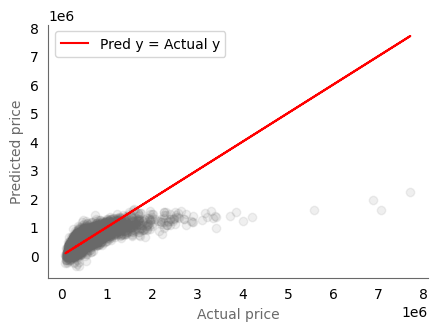

In [28]:
predictors = ['bathrooms', 'bedrooms', 'condition', 'grade', 'sqft_living15', 'sqft_living', 'sqft_lot', 'view', 'yr_built', 'zipcode_price']
X_train, X_test = train_df.loc[:, predictors], test_df.loc[:, predictors]
y_train, y_test = train_df.loc[:, train_df.columns == 'price'], test_df.loc[:, test_df.columns == 'price']

r2, mae, rmse = [], [], []
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution='normal')), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(f"R^2: {np.mean(r2_score(y_test, y_pred))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(y_test, y_pred, color='dimgray', alpha=0.1)
axes.plot(y_test, y_test, color='red', label='Pred y = Actual y')
axes.set_xlabel('Actual price', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted price', fontsize=10, color='dimgray')
axes.legend();

# Polynomial regression
***Key observations***

# Regularisation
***Key observations***